<a href="https://colab.research.google.com/github/AayushKK/Tumor-Segmentation/blob/main/Unetfortumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import json
from zipfile import ZipFile
import shutil
from glob import glob
from tqdm import tqdm

#Data
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("dark_background")

#Image
import cv2 as cv
import cv2
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

#keras
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings("ignore")

In [ ]:
IMG_SIZE = (256,256)

In [ ]:
train_files = []
mask_files = glob("/content/drive/MyDrive/brain/lgg-mri-segmentation/kaggle_3m/*/*_mask*")

for f in tqdm(mask_files):
    train_files.append(f.replace('_mask', ''))

100%|██████████| 3929/3929 [00:00<00:00, 584957.42it/s]


In [ ]:
df = pd.DataFrame({"image_path": train_files, "mask_path":mask_files})

In [ ]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.15, shuffle = True)
df_train, df_val = train_test_split(df_train, test_size=0.15, shuffle = True)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(2838, 2)
(501, 2)
(590, 2)


In [ ]:
def adjust(img,mask):
    #normalization
    img = img / 255.

    #mask
    mask = mask / 255.
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0

    return (img, mask)

In [ ]:
train_gen_aug = dict(rotation_range=0.2,
                        width_shift_range=0.05,
                        height_shift_range=0.05,
                        shear_range=0.05,
                        zoom_range=0.05,
                        horizontal_flip=True,
                        fill_mode='nearest')

In [ ]:
def train_generator(dataframe, batch_size, aug_dict,
                    image_color_mode = "rgb",
                    mask_color_mode = "grayscale",
                    image_save_prefix = "image",
                    mask_save_prefix = "mask",
                    save_to_dir = None,
                    target_size = (256,256),
                    seed = 1):
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)

  #image
    image_generator = image_datagen.flow_from_dataframe(
          dataframe,
          x_col = "image_path",
          target_size = target_size,
          batch_size = batch_size,
          class_mode = None,
          color_mode = image_color_mode,
          save_to_dir = save_to_dir,
          save_prefix = image_save_prefix,
          seed = seed )

      #mask
    mask_generator = mask_datagen.flow_from_dataframe(
          dataframe,
          x_col = "mask_path",
          target_size = target_size,
          batch_size = batch_size,
          class_mode = None,
          color_mode = mask_color_mode,
          save_to_dir = save_to_dir,
          save_prefix = mask_save_prefix,
          seed = seed)

  #combining the generators to make a whole generator
    train_gen = zip(image_generator, mask_generator)

  #data adjustment
    for (img, mask) in train_gen:
        img, mask = adjust(img, mask)
        yield (img,mask)

In [ ]:
def DoubleConv(inp, filters, dropout=0.1):
  #A 3X3 2D conv-dropout-conv trio
    layer1 = Conv2D(filters = filters, kernel_size = (3,3), activation= "relu", kernel_initializer= "he_normal", padding = "same")(inp)
    layer2 = Dropout(rate = dropout)(layer1)
    layer3 = Conv2D(filters= filters, kernel_size= (3,3), activation= "relu", kernel_initializer= "he_normal", padding = "same")(layer2)
    out = BatchNormalization(axis = 3)(layer3)
    return out

In [ ]:
def unet(input_size = (256,256,3)):
    #Input Layer
    inputs = Input(input_size)

    #Encoder network
    conv1 = DoubleConv(inputs,16)
    pool1 = MaxPooling2D(pool_size= (2,2))(conv1)

    conv2 = DoubleConv(pool1,32)
    pool2 = MaxPooling2D(pool_size= (2,2))(conv2)

    conv3 = DoubleConv(pool2,64)
    pool3 = MaxPooling2D(pool_size= (2,2))(conv3)

    conv4 = DoubleConv(pool3,128)
    pool4 = MaxPooling2D(pool_size= (2,2))(conv4)

    conv5 = DoubleConv(pool4,256)

    #decoder network
    up6 = Conv2DTranspose(128, (2,2), strides = (2,2), padding = "same")(conv5)
    up6 = concatenate([up6, conv4], axis = 3)
    conv6 = DoubleConv(up6, 128)

    up7 = Conv2DTranspose(64, (2,2), strides = (2,2), padding = "same")(conv6)
    up7 = concatenate([up7, conv3], axis = 3)
    conv7 = DoubleConv(up7, 64)

    up8 = Conv2DTranspose(32, (2,2), strides = (2,2), padding = "same")(conv7)
    up8 = concatenate([up8, conv2], axis = 3)
    conv8 = DoubleConv(up8, 32)

    up9 = Conv2DTranspose(16, (2,2), strides = (2,2), padding = "same")(conv8)
    up9 = concatenate([up9, conv1], axis = 3)
    conv9 = DoubleConv(up9, 16)

    #output layer
    conv10 = Conv2D(1, (1,1), activation= "sigmoid")(conv9)

    model = Model(inputs = [inputs], outputs = [conv10])

    return model

In [ ]:
BATCH_SIZE = 32

In [ ]:
train_gen = train_generator(df_train, batch_size= BATCH_SIZE,
                            aug_dict = train_gen_aug,
                            target_size = IMG_SIZE)
test_gen = train_generator(df_val, batch_size = BATCH_SIZE,
                           aug_dict = dict(),
                           target_size = IMG_SIZE)
model = unet((IMG_SIZE[0], IMG_SIZE[1], 3))

In [ ]:
EPOCHS = 35
BATCH_SIZE = 32
learning_rate = 0.05

In [ ]:
from keras import backend as K
import numpy as np
import tensorflow as tf
from scipy.ndimage import distance_transform_edt as distance


def calc_dist_map(seg):
    res = np.zeros_like(seg)
    posmask = seg.astype(np.bool)

    if posmask.any():
        negmask = ~posmask
        res = distance(negmask) * negmask - (distance(posmask) - 1) * posmask

    return res


def calc_dist_map_batch(y_true):
    y_true_numpy = y_true.numpy()
    return np.array([calc_dist_map(y)
                     for y in y_true_numpy]).astype(np.float32)


def surface_loss(y_true, y_pred):
    y_true_dist_map = tf.py_function(func=calc_dist_map_batch,
                                     inp=[y_true],
                                     Tout=tf.float32)
    multipled = y_pred * y_true_dist_map
    return K.mean(multipled)

In [ ]:
from keras.losses import binary_crossentropy

beta = 0.25
alpha = 0.25
gamma = 2
epsilon = 1e-5
smooth = 1


class Semantic_loss_functions(object):
    def __init__(self):
        print ("semantic loss functions initialized")

    def dice_coef(self, y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + K.epsilon()) / (
                    K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

    def sensitivity(self, y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        return true_positives / (possible_positives + K.epsilon())

    def specificity(self, y_true, y_pred):
        true_negatives = K.sum(
            K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
        possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
        return true_negatives / (possible_negatives + K.epsilon())

    def convert_to_logits(self, y_pred):
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(),
                                  1 - tf.keras.backend.epsilon())
        return tf.math.log(y_pred / (1 - y_pred))

    def weighted_cross_entropyloss(self, y_true, y_pred):
        y_pred = self.convert_to_logits(y_pred)
        pos_weight = beta / (1 - beta)
        loss = tf.nn.weighted_cross_entropy_with_logits(y_true,y_pred,pos_weight)
        return tf.reduce_mean(loss)

    def focal_loss_with_logits(self, logits, targets, alpha, gamma, y_pred):
        weight_a = alpha * (1 - y_pred) ** gamma * targets
        weight_b = (1 - alpha) * y_pred ** gamma * (1 - targets)

        return (tf.math.log1p(tf.exp(-tf.abs(logits))) + tf.nn.relu(
            -logits)) * (weight_a + weight_b) + logits * weight_b

    def focal_loss(self, y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(),
                                  1 - tf.keras.backend.epsilon())
        logits = tf.math.log(y_pred / (1 - y_pred))

        loss = self.focal_loss_with_logits(logits=logits, targets=y_true,
                                      alpha=alpha, gamma=gamma, y_pred=y_pred)

        return tf.reduce_mean(loss)

    def depth_softmax(self, matrix):
        sigmoid = lambda x: 1 / (1 + K.exp(-x))
        sigmoided_matrix = sigmoid(matrix)
        softmax_matrix = sigmoided_matrix / K.sum(sigmoided_matrix, axis=0)
        return softmax_matrix

    def dice_coefficient(self, y_true, y_pred):
        smooth = 1.
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        score = (2. * intersection + smooth) / (
                    K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
        return score

    def dice_loss(self, y_true, y_pred):
        loss = 1 - self.dice_coefficient(y_true, y_pred)
        return loss

    def bce_dice_loss(self, y_true, y_pred):
        loss = binary_crossentropy(y_true, y_pred) + \
               self.dice_loss(y_true, y_pred)
        return loss / 2.0

    def confusion(self, y_true, y_pred):
        smooth = 1
        y_pred_pos = K.clip(y_pred, 0, 1)
        y_pred_neg = 1 - y_pred_pos
        y_pos = K.clip(y_true, 0, 1)
        y_neg = 1 - y_pos
        tp = K.sum(y_pos * y_pred_pos)
        fp = K.sum(y_neg * y_pred_pos)
        fn = K.sum(y_pos * y_pred_neg)
        prec = (tp + smooth) / (tp + fp + smooth)
        recall = (tp + smooth) / (tp + fn + smooth)
        return prec, recall

    def true_positive(self, y_true, y_pred):
        smooth = 1
        y_pred_pos = K.round(K.clip(y_pred, 0, 1))
        y_pos = K.round(K.clip(y_true, 0, 1))
        tp = (K.sum(y_pos * y_pred_pos) + smooth) / (K.sum(y_pos) + smooth)
        return tp

    def true_negative(self, y_true, y_pred):
        smooth = 1
        y_pred_pos = K.round(K.clip(y_pred, 0, 1))
        y_pred_neg = 1 - y_pred_pos
        y_pos = K.round(K.clip(y_true, 0, 1))
        y_neg = 1 - y_pos
        tn = (K.sum(y_neg * y_pred_neg) + smooth) / (K.sum(y_neg) + smooth)
        return tn

    def tversky_index(self, y_true, y_pred):
        y_true_pos = K.flatten(y_true)
        y_pred_pos = K.flatten(y_pred)
        true_pos = K.sum(y_true_pos * y_pred_pos)
        false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
        false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
        alpha = 0.7
        return (true_pos + smooth) / (true_pos + alpha * false_neg + (
                    1 - alpha) * false_pos + smooth)

    def tversky_loss(self, y_true, y_pred):
        return 1 - self.tversky_index(y_true, y_pred)

    def focal_tversky(self, y_true, y_pred):
        pt_1 = self.tversky_index(y_true, y_pred)
        gamma = 0.75
        return K.pow((1 - pt_1), gamma)

    def log_cosh_dice_loss(self, y_true, y_pred):
        x = self.dice_loss(y_true, y_pred)
        return tf.math.log((tf.exp(x) + tf.exp(-x)) / 2.0)

    def loss(self, y_true, y_pred):
        return 0.5*s.focal_tversky(y_true, y_pred) + 0.2*self.weighted_cross_entropyloss(y_true, y_pred) + 0.3*surface_loss(y_true, y_pred)

s = Semantic_loss_functions()

semantic loss functions initialized


In [ ]:
decay_rate = learning_rate / EPOCHS
opt = Adam(learning_rate=learning_rate, epsilon= 0.1, decay=decay_rate, amsgrad=False)

In [ ]:
model.compile(optimizer = opt, loss = s.loss, metrics = ["binary_accuracy", s.tversky_index, s.dice_coefficient, s.sensitivity, s.specificity ])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
#callbacks
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=20
                             )
# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="unet.hdf5",
                               verbose=1,
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )

In [ ]:
history = model.fit(train_gen,
          steps_per_epoch = len(df_train)/BATCH_SIZE,
          epochs = EPOCHS,
          callbacks = [checkpointer, earlystopping, reduce_lr],
          validation_data = test_gen,
          validation_steps= len(df_val)/ BATCH_SIZE)

Found 2838 validated image filenames.
Found 2838 validated image filenames.
Epoch 1/35
89/88 [==============================] - ETA: -7s - loss: 1.0410 - binary_accuracy: 0.9278 - tversky_index: 0.2846 - dice_coefficient: 0.2505 - sensitivity: 0.5251 - specificity: 0.9320Found 501 validated image filenames.
Found 501 validated image filenames.

Epoch 1: val_loss improved from inf to 0.47168, saving model to unet.hdf5
88/88 [==============================] - 2485s 28s/step - loss: 1.0410 - binary_accuracy: 0.9278 - tversky_index: 0.2846 - dice_coefficient: 0.2505 - sensitivity: 0.5251 - specificity: 0.9320 - val_loss: 0.4717 - val_binary_accuracy: 0.9887 - val_tversky_index: 0.0996 - val_dice_coefficient: 0.1253 - val_sensitivity: 0.0681 - val_specificity: 0.9997 - lr: 0.0500
Epoch 2/35
89/88 [==============================] - ETA: 0s - loss: 0.3271 - binary_accuracy: 0.9900 - tversky_index: 0.4775 - dice_coefficient: 0.4730 - sensitivity: 0.4929 - specificity: 0.9951
Epoch 2: val_loss 

In [ ]:
model.save_weights("/content/drive/MyDrive/unet_model.h5")

In [ ]:
model_json = model.to_json()
with open("unet_model", "w") as json_file:
    json_file.write(model_json)

In [ ]:
test_gen = train_generator(df_test, BATCH_SIZE,
                                dict(),
                                target_size=IMG_SIZE)
results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)
print("Test loss: ",results[0])
print("Test accuracy: ",results[1])
print("Test tversky: ",results[2])
print("Test Dice Coefficent: ",results[3])
print("Test sensitivity: ",results[4])
print("Test specificity: ",results[5])

Found 590 validated image filenames.
Found 590 validated image filenames.
18/18 [==============================] - 8s 406ms/step - loss: 0.1472 - binary_accuracy: 0.9941 - tversky_index: 0.8012 - dice_coefficient: 0.7530 - sensitivity: 0.8905 - specificity: 0.9952
Test loss:  0.14715930819511414
Test accuracy:  0.9940845370292664
Test tversky:  0.8011676669120789
Test Dice Coefficent:  0.753018319606781
Test sensitivity:  0.8905048370361328
Test specificity:  0.9952362179756165


In [ ]:
for index in range(len(df_test)):
    img = cv.imread(df_test['image_path'].iloc[index])
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = cv.resize(img ,IMG_SIZE)
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)
    img = np.squeeze(img)

    original = img.copy()
    fig, ax = plt.subplots(1,3,figsize = (15,5))
    ax[0].imshow(original)
    ax[0].set_xlabel('Original Image')

    main = original.copy()
    label = cv.imread(df_test['mask_path'].iloc[index])
    sample = np.array(np.squeeze(label), dtype = np.uint8)
    sample = cv.resize(sample ,IMG_SIZE)
    contours, hier = cv2.findContours(sample[:,:,0],cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    sample_over_gt = cv2.drawContours(main, contours, -1,[0,255,0], thickness=-1)
    ax[1].imshow(sample_over_gt)
    ax[1].set_xlabel('Ground Truth')

    main = original.copy()
    sample = np.array(np.squeeze(pred) > 0.5, dtype = np.uint8)
    contours, hier = cv2.findContours(sample,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    sample_over_pr = cv2.drawContours(main, contours, -1, [0,255,0], thickness=-1)
    ax[2].imshow(sample_over_pr)
    ax[2].set_xlabel("Unet Prediction")

plt.show()

In [ ]:
def plot_segm_history(history, metrics, losses, name):
    """[summary]

    Args:
        history ([type]): [description]
        metrics (list, optional): [description]. Defaults to ["iou", "val_iou"].
        losses (list, optional): [description]. Defaults to ["loss", "val_loss"].
    """
    # summarize history for iou
    plt.figure(figsize=(12, 6))
    for metric in metrics:
        plt.plot(history.history[metric], linewidth=3)
    plt.suptitle(f"{name} vs epochs", fontsize=20)
    plt.ylabel(f"{name}", fontsize=20)
    plt.xlabel("epoch", fontsize=20)
    # plt.yticks(np.arange(0.3, 1, step=0.02), fontsize=35)
    # plt.xticks(fontsize=35)
    plt.legend(metrics, loc="center right", fontsize=15)
    plt.savefig(f"{name}.png")
    plt.show()
    # summarize history for loss
    plt.figure(figsize=(12, 6))
    for loss in losses:
        plt.plot(history.history[loss], linewidth=3)
    plt.suptitle("loss over epochs", fontsize=20)
    plt.ylabel("loss", fontsize=20)
    plt.xlabel("epoch", fontsize=20)
    # plt.yticks(np.arange(0, 0.2, step=0.005), fontsize=35)
    # plt.xticks(fontsize=35)
    plt.legend(losses, loc="center right", fontsize=15)
    plt.savefig("unet_loss.png")
    plt.show()

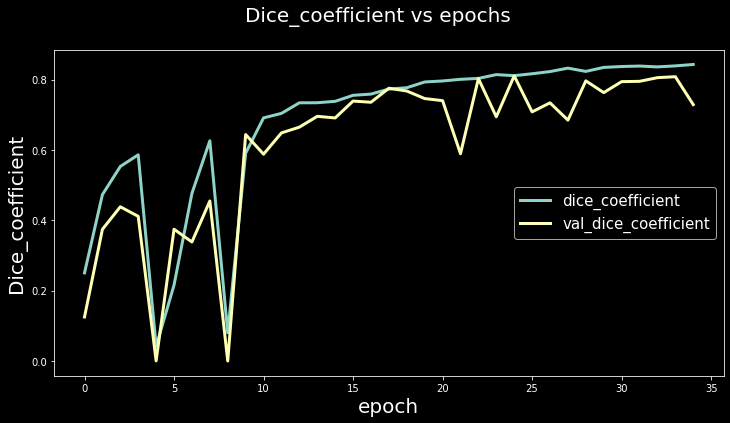

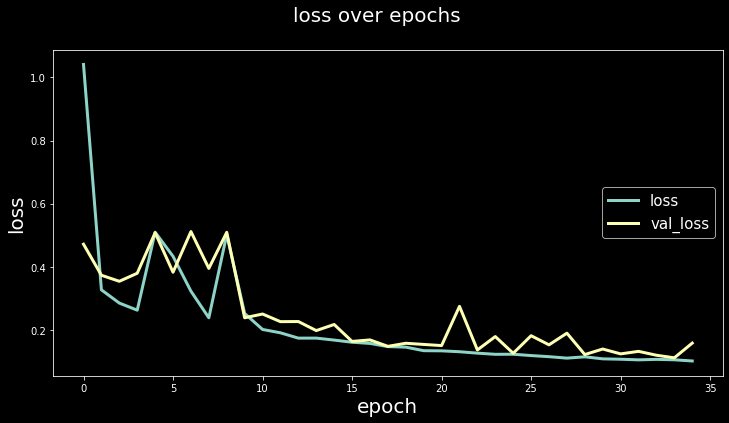

In [ ]:
plot_segm_history(
    history, # required - keras training history object
    ['dice_coefficient', 'val_dice_coefficient'], # optional - metrics names to plot
    ['loss', 'val_loss'], 'Dice_coefficient') # optional - loss names to plot

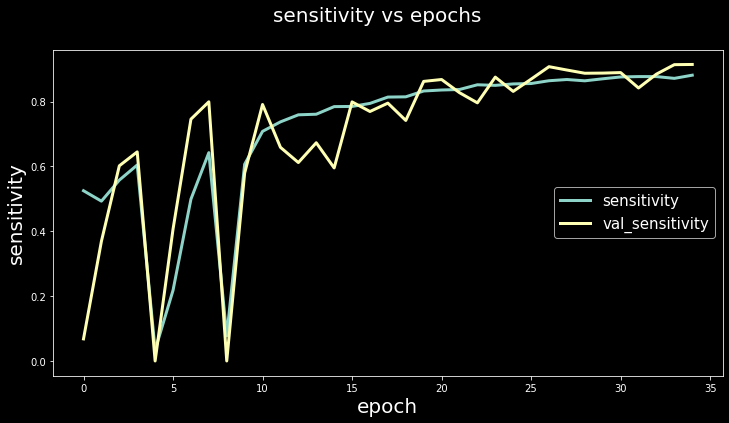

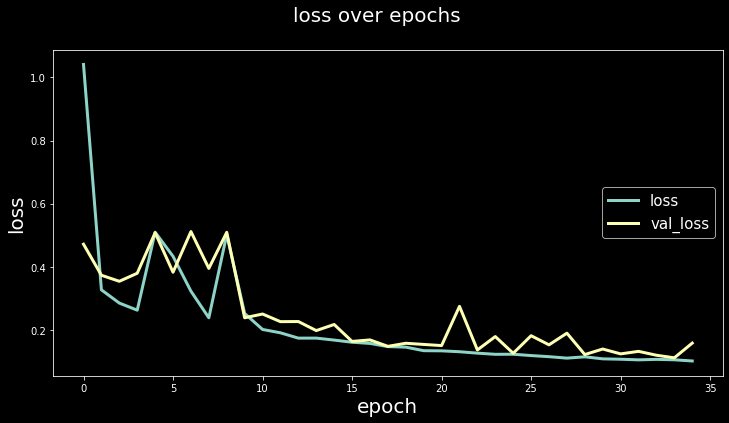

In [ ]:
plot_segm_history(
    history, # required - keras training history object
    ['sensitivity', 'val_sensitivity'], # optional - metrics names to plot
    ['loss', 'val_loss'], 'sensitivity') # optional - loss names to plot

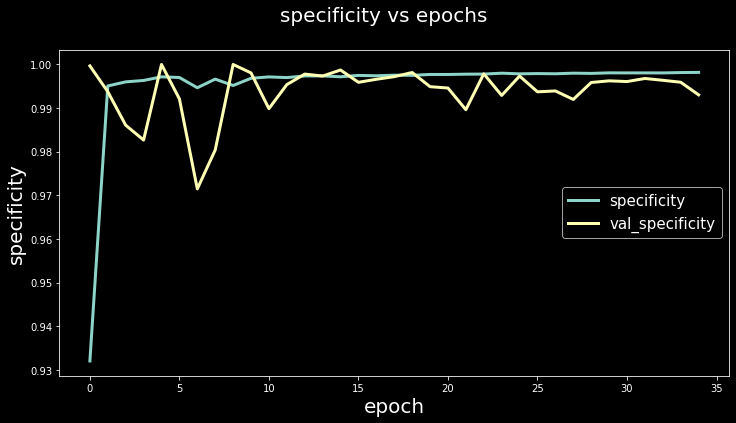

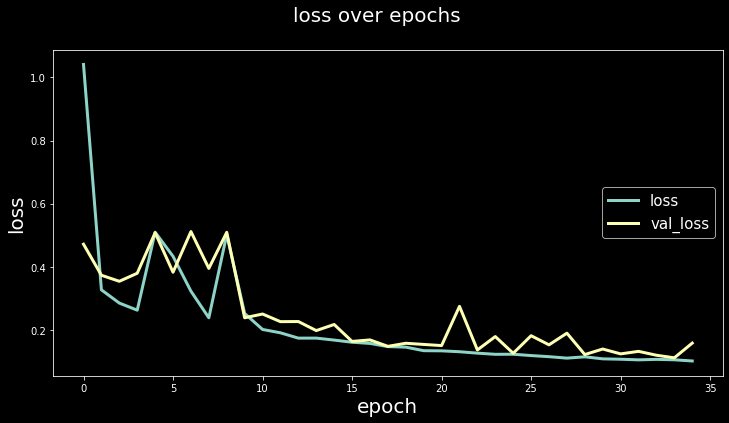

In [ ]:
plot_segm_history(
    history, # required - keras training history object
    ['specificity', 'val_specificity'], # optional - metrics names to plot
    ['loss', 'val_loss'], 'specificity') # optional - loss names to plot

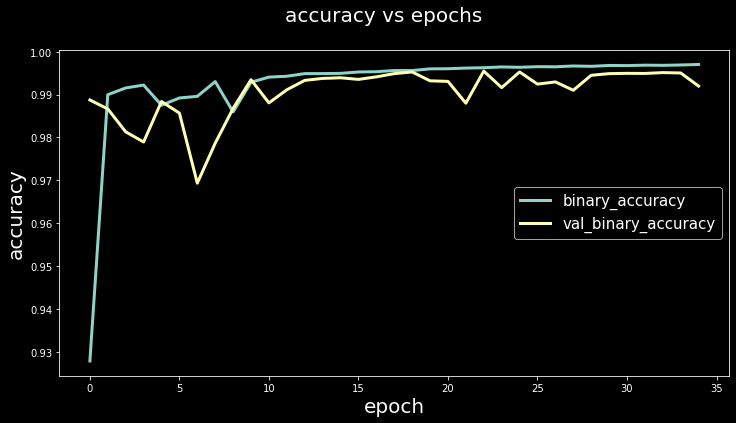

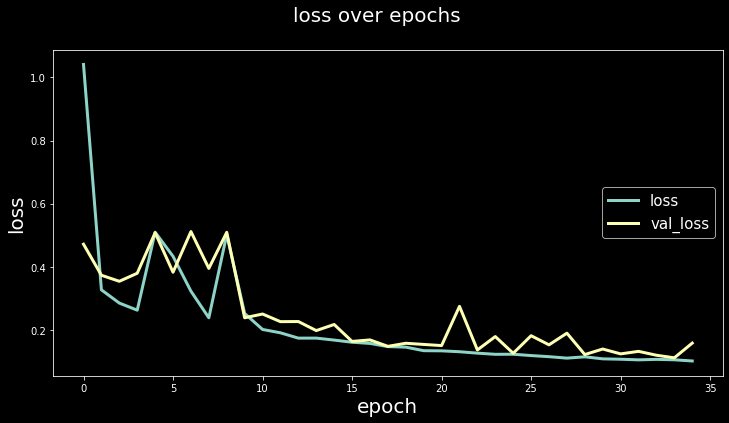

In [ ]:
plot_segm_history(
    history, # required - keras training history object
    ['binary_accuracy', 'val_binary_accuracy'], # optional - metrics names to plot
    ['loss', 'val_loss'], 'accuracy') # optional - loss names to plot

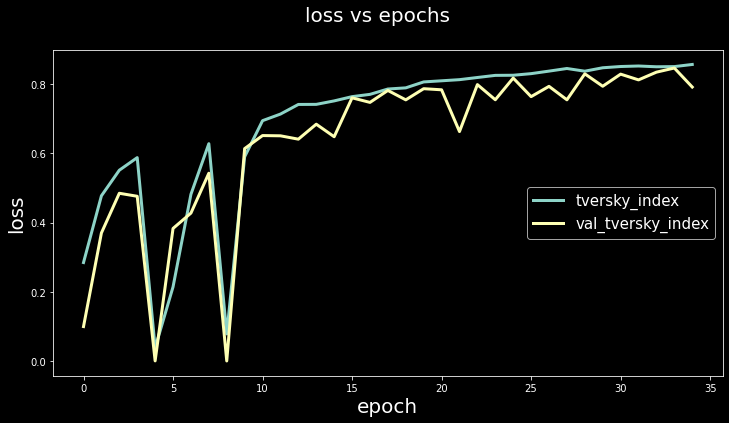

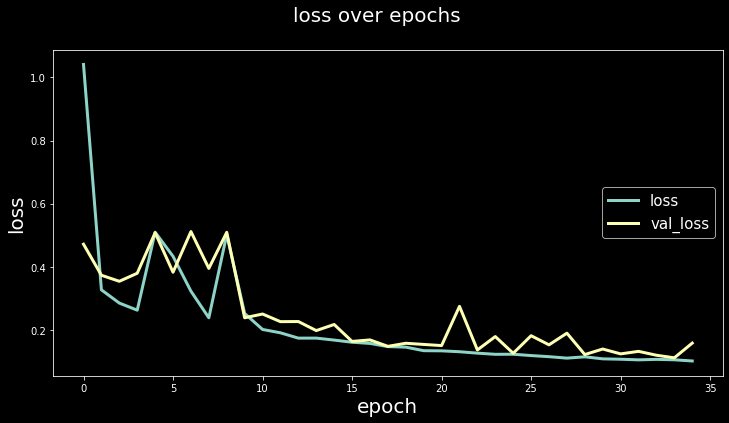

In [ ]:
plot_segm_history(
    history, # required - keras training history object
    ['tversky_index', 'val_tversky_index'], # optional - metrics names to plot
    ['loss', 'val_loss'], 'loss') # optional - loss names to plo